# 4. Classificação em classes espectrais de água

### Sumário

  4.1 Acessando os dados

  4.2 Segmentando os dados

  4.3 Visualizando a dispersão dos dados

  4.4 Classificação em classes espectrais de água
  
    4.4.1 Definindo as classes espectrais de água
   
    4.4.2 Visualização das classes espectrais de água obtidas

  4.5 Classificação supervisionada de classes de água espectrais
  
    4.5.1 Visualizando as matrizes de 
   
    4.5.2 Comparação dos espectros de treino e os obtido pelas classificações através do espectro normalizado, SAM, OLI e MSI    A normalizado

  5.Conclusão


##### 4.1 Acessando os dados

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')

# Definindo o diretório raiz de todos os dados
os.chdir(r'C:\Users\Edson\Documents\MEGAsync\ser\Data Science\Projeto\Dados_pre_processados')

In [2]:
Spec = pd.read_csv('Rrs_nonoisy_sample_means', header = 0, index_col = 0)
Bandas = pd.read_csv('Bandas_Simuladas.csv', header = 0, index_col = 0)

São utilizados duas formas de classificação em classes espectrais de água: (1) As bandas multiespectrais, (2) todo espectro com Rrs, (3) Todo espectro com a Rrs normalizada e (4) todo espectro utilizando SAM (spectral angle mapper). Os itens 1 e 2 já estão disponíveis, enquanto o 3 deve ser gerado, e 4 é calculado a partir do item 2.

##### 4.2 Segmentando os dados

Serão gerados 8 conjunto de dados para classificação: (1) Espectral, (2) Espectral Normalizada, (3) OLI, (4) MSI A, (5) MSI B, (6) OLI Normalizada, (7) MSI A Normalizada e (8) MSI B Normalizada

In [3]:
# Gerando Espectro Normalizado
Spec_Norm = cp.copy(Spec)
for x in Spec_Norm.index:
    Spec_Norm.loc[x] = Spec.loc[x] / Spec.loc[x].sum()

In [4]:
# Separando as bandas por sensor
OLI = Bandas[Bandas.columns[0:5]]
MSIB = Bandas[Bandas.columns[5:15]]
MSIA = Bandas[Bandas.columns[15:]]

In [5]:
# Gerando Bandas Normalizadas
OLI_Norm = cp.copy(OLI)
MSIB_Norm = cp.copy(MSIB)
MSIA_Norm = cp.copy(MSIA)

for x in OLI_Norm.index:
    OLI_Norm.loc[x] = OLI.loc[x] / OLI.loc[x].sum()
    
for x in MSIB_Norm.index:
    MSIB_Norm.loc[x] = MSIB.loc[x] / MSIB.loc[x].sum()
    
for x in MSIA_Norm.index:
    MSIA_Norm.loc[x] = MSIA.loc[x] / MSIA.loc[x].sum()

#### 4.3 Visualizando a dispersão dos dados

Dispersão do espectro original e normalizado


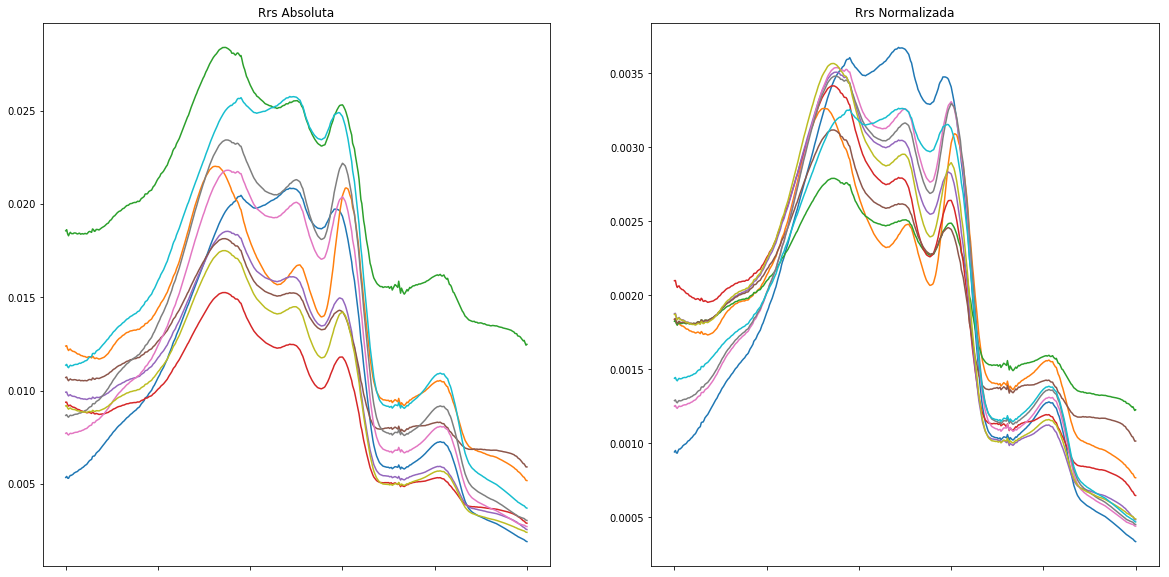

In [6]:
print('Dispersão do espectro original e normalizado')
plt.figure(figsize=(20,10))
ax1=plt.subplot(1,2,1)
Spec.transpose()[Spec.index[0:10]].plot(legend=False, title = 'Rrs Absoluta',ax=ax1)

ax2=plt.subplot(1,2,2)
Spec_Norm.transpose()[Spec_Norm.index[0:10]].plot(legend=False, title = 'Rrs Normalizada',ax=ax2);

Como observado na figura acima, a normalização pela integral (ou soma) reduz o efeito da intensidade da Rrs, colocando os espectros em uma mesma escala.

Comparação entre as bandas originais e normalizadas


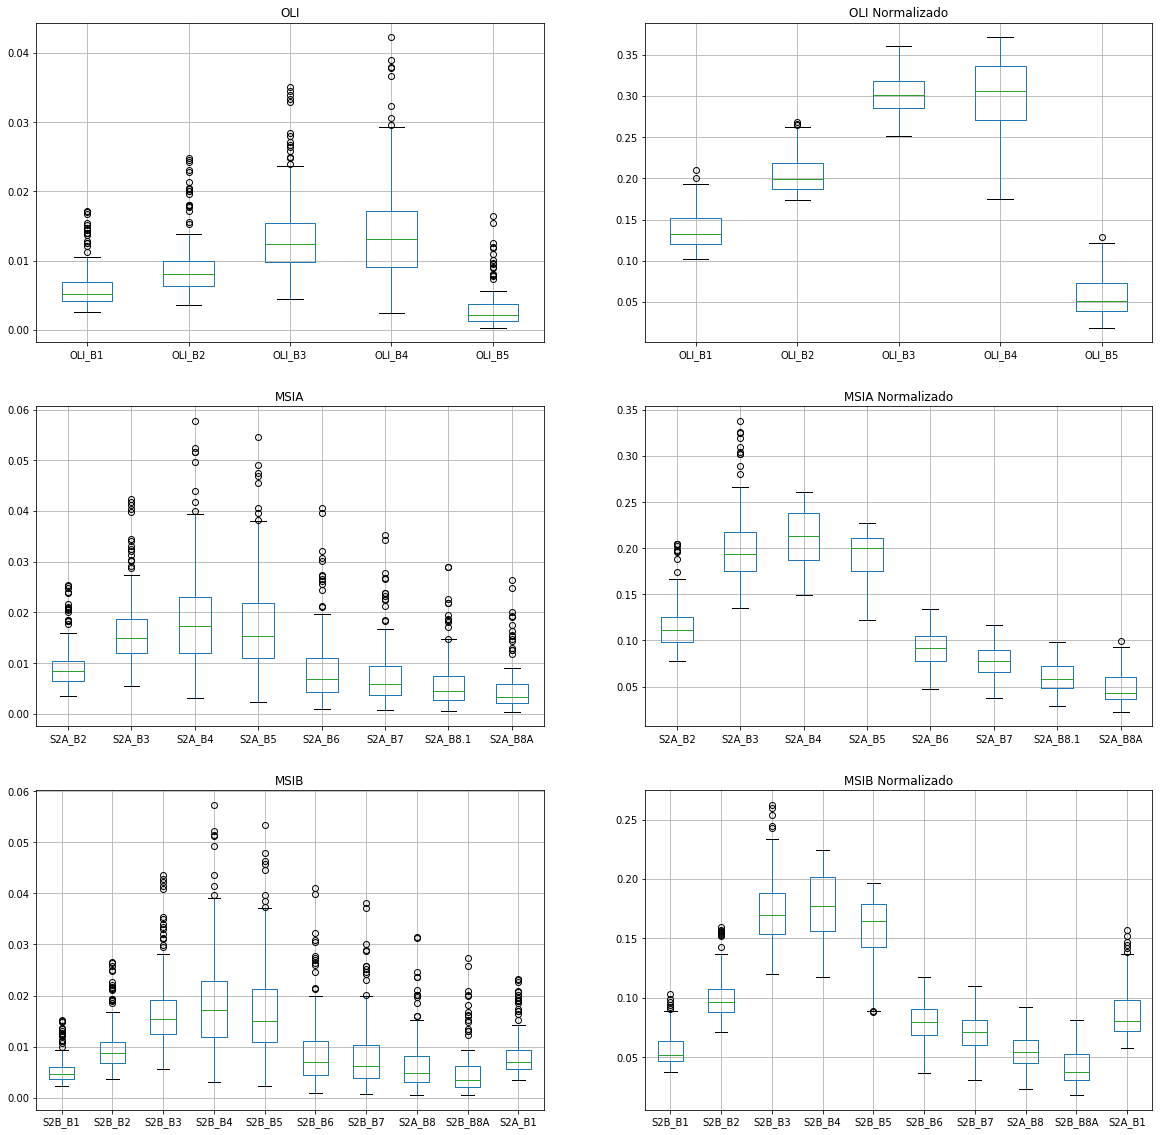

In [7]:
ax=plt.figure(figsize=(20,20))
print("Comparação entre as bandas originais e normalizadas")
ax1=plt.subplot(3,2,1)
OLI.boxplot(ax=ax1)
ax1.set_title('OLI')

ax2=plt.subplot(3,2,2)
OLI_Norm.boxplot(ax=ax2)
ax2.set_title('OLI Normalizado')

ax3=plt.subplot(3,2,3)
MSIA.boxplot(ax=ax3)
ax3.set_title('MSIA')

ax4=plt.subplot(3,2,4)
MSIA_Norm.boxplot(ax=ax4)
ax4.set_title('MSIA Normalizado')

ax5=plt.subplot(3,2,5)
MSIB.boxplot(ax=ax5)
ax5.set_title('MSIB')

ax6=plt.subplot(3,2,6)
MSIB_Norm.boxplot(ax=ax6)
ax6.set_title('MSIB Normalizado');


Observando os boxplots de todas bandas, podemos ver que a normalização pela soma das bandas reduz o número de outliers.

Bandas OLI Originais


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


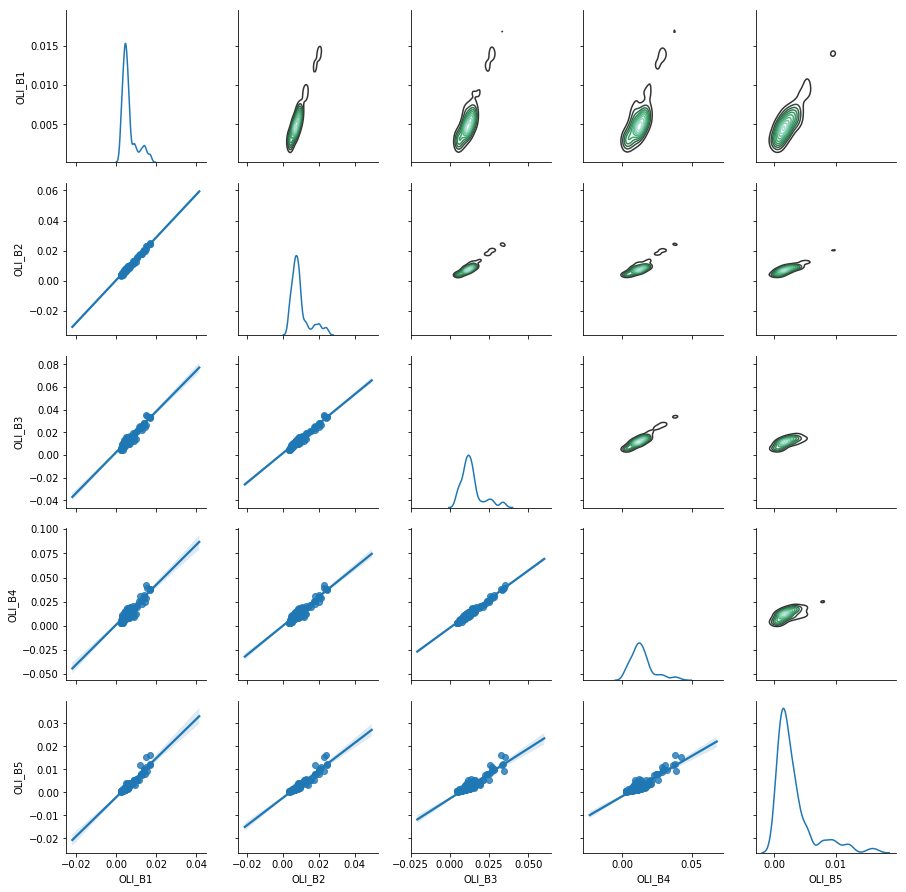

In [8]:
print('Bandas OLI Originais')
g = sns.PairGrid(OLI);
g.map_lower(sns.regplot);
g.map_upper(sns.kdeplot);
g.map_diag(sns.kdeplot);

Banda OLI Normalizadas


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


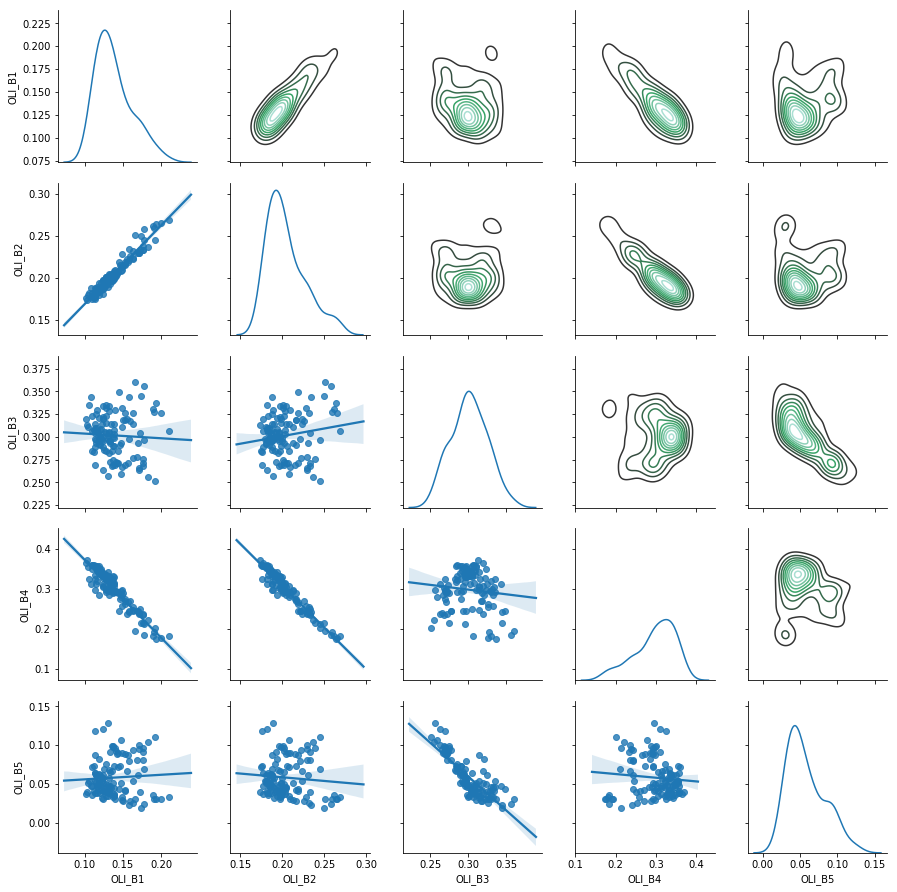

In [9]:
print('Banda OLI Normalizadas')
g = sns.PairGrid(OLI_Norm);
g.map_lower(sns.regplot);
g.map_upper(sns.kdeplot);
g.map_diag(sns.kdeplot);

Como observado nas figuras acima, a normalização realça a forma do espectro e reduz a diferença causada pela intensidade. Além disso, a normalização das bandas descorrelaciona os dados e acentua agrupamentos diferentes.

#### 4.4 Classificação em classes espectrais de água

Esta etapa é o objetivo final do trabalho, onde: (1) Será segmentado (classificação não supervisionada) em classes de águas espectrais utilizando a Rrs normalizada utilizando dados hiperespectrais de treino; (2) Em um conjunto de dados teste, será classificado as classes obtidas utilizando os dados hiperespectrais e as bandas simuladas. Por último, será avaliado se as bandas dos sensores OLI e MSI são capazes de se classificar tipos de águas definidas por dados hiperespectrais.

In [10]:
#Separando os dados em treino e teste
X_train, X_test = train_test_split(Spec_Norm, test_size=0.5)

##### 4.4.1 Definindo as classes espectrais de água
Classificação não supervisionada

In [11]:
# Classificação não supervisionada
n_cluster = 5
    
Classes = KMeans(n_clusters=n_cluster,tol=0.00001).fit_predict(X_train)

X_train['Classes'] = Classes

In [12]:
#Agrupando as classes para visualização por comprimento de onda para os dados normalizados
X_train_mean = X_train.groupby('Classes').mean()
X_train_std = X_train.groupby('Classes').std()

index = [int(x) for x in X_train_mean.columns[0:501]]
X_train_mean = X_train_mean[X_train_mean.columns[0:501]].transpose()
X_train_mean.index = index

X_train_std = X_train_std[X_train_std.columns[0:501]].transpose()
X_train_std.index = index

# Gerando um dataframe para o espectro normal com as classes atribuídas
Spec_Classes = Spec.join(X_train['Classes']).dropna()

Spec_Classes_mean = Spec_Classes.groupby('Classes').mean()
Spec_Classes_std = Spec_Classes.groupby('Classes').std()

index = [int(x) for x in Spec_Classes_mean.columns[0:501]]
Spec_Classes_mean = Spec_Classes_mean[Spec_Classes_mean.columns[0:501]].transpose()
Spec_Classes_mean.index = index

Spec_Classes_std = Spec_Classes_std[Spec_Classes_std.columns[0:501]].transpose()
Spec_Classes_std.index = index

In [13]:
# Gerando datasets de treino para os classificadores supervisionados

# Gerando um dataframe para as bandas OLI simuladas com as classes atribuídas
OLI_Train = OLI.join(X_train['Classes']).dropna()

# Gerando um dataframe para as bandas OLI simuladas com as classes atribuídas
MSIA_Train = MSIA.join(X_train['Classes']).dropna()

# Gerando um dataframe para as bandas OLI simuladas com as classes atribuídas
MSIB_Train = MSIB.join(X_train['Classes']).dropna()

# Gerando um dataframe para as bandas OLI simuladas e normalizadas com as classes atribuídas
OLI_Norm_Train = OLI_Norm.join(X_train['Classes']).dropna()

# Gerando um dataframe para as bandas OLI simuladas e normalizadas com as classes atribuídas
MSIA_Norm_Train = MSIA_Norm.join(X_train['Classes']).dropna()

# Gerando um dataframe para as bandas OLI simuladas e normalizadas com as classes atribuídas
MSIB_Norm_Train = MSIB_Norm.join(X_train['Classes']).dropna()

# Criando uma lista de todos datasets de treino para os classificadores supervisionados
datasetsTrain = ['X_train','Spec_Classes','OLI_Train','MSIA_Train','MSIB_Train','OLI_Norm_Train',
            'MSIA_Norm_Train','MSIB_Norm_Train']


##### 4.4.2 Visualização das classes espectrais de água obtidas

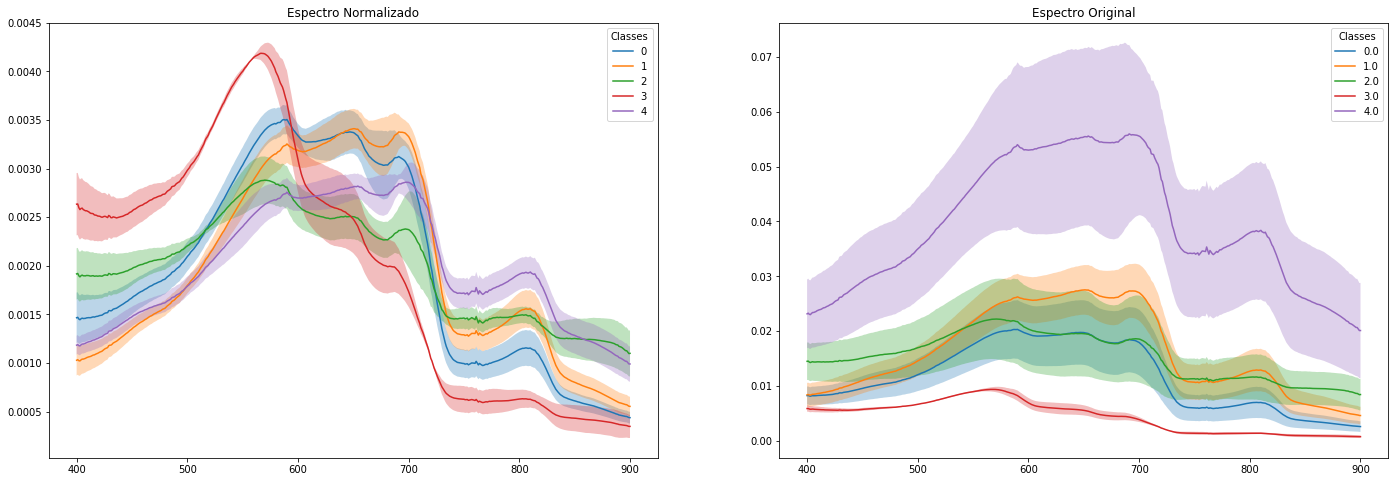

In [14]:
#Gerando o gráfico de visualização das classes obtidas
plt.figure(figsize=(24,8))

ax1=plt.subplot(1,2,1)
X_train_mean.plot(ax=ax1)

for x in X_train_mean:
    plt.fill_between(X_train_mean.index,(X_train_mean[x] - X_train_std[x]),(X_train_mean[x] + X_train_std[x]), alpha=0.3)
    
plt.title("Espectro Normalizado")
ax2=plt.subplot(1,2,2)
Spec_Classes_mean.plot(ax=ax2)

for x in X_train_mean:
    plt.fill_between(Spec_Classes_mean.index,(Spec_Classes_mean[x] - Spec_Classes_std[x]),
                     (Spec_Classes_mean[x] + Spec_Classes_std[x]), alpha=0.3)
    
plt.title("Espectro Original");
 

Como observado acima, o espectro Normalizado (utilizado na classificação não supervisionada) apresenta faixas de comprimentos de ondas que conseguem distinguir bem cada classe. Por outro lado, O espectro original não apresenta uma diferenciação tão evidente, onde apenas as classes 4 e 3 são facilmente separadas.

Distribuição das classes no sensor OLI não normalizado


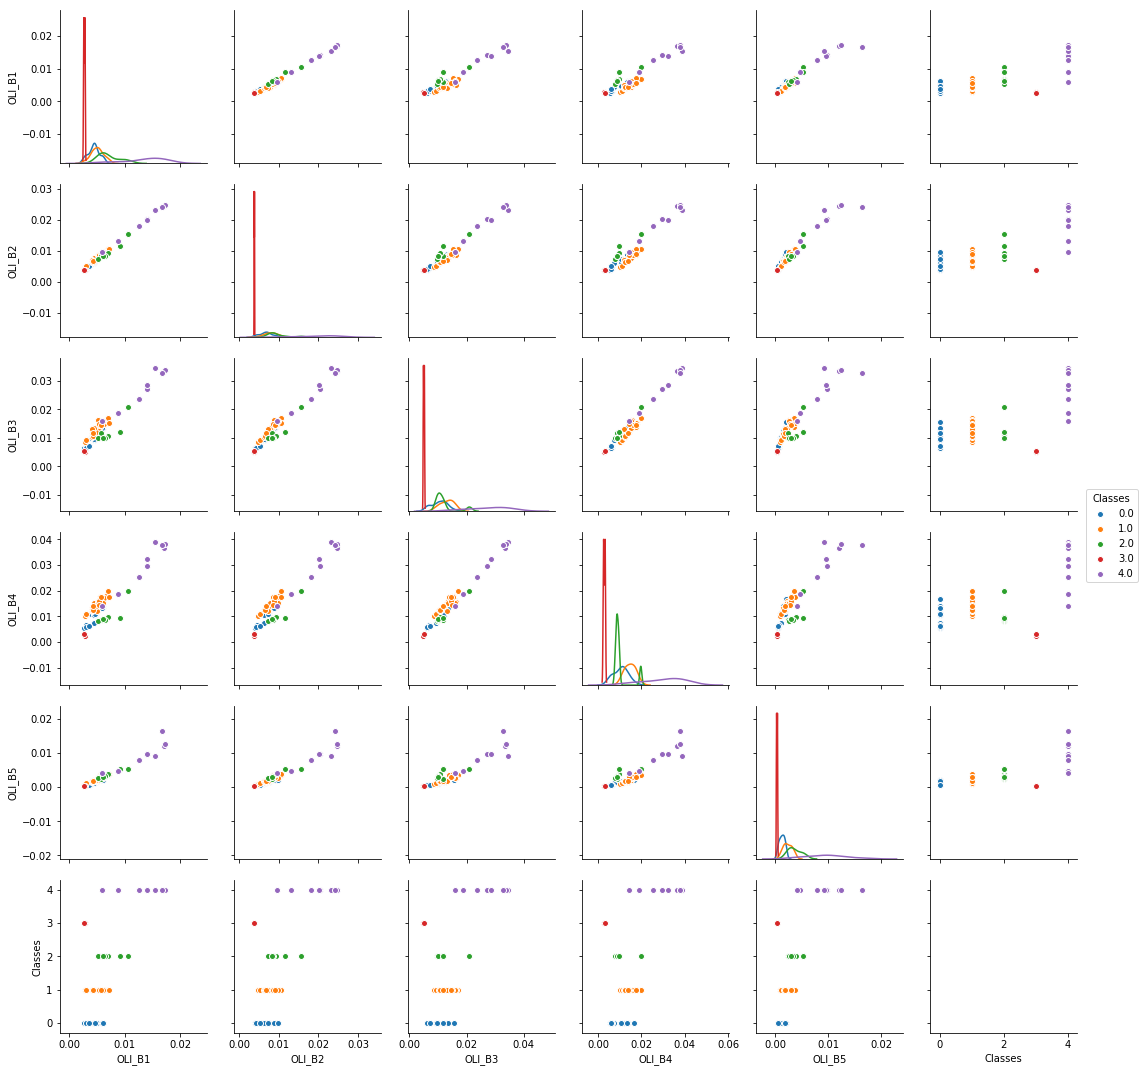

In [15]:
print('Distribuição das classes no sensor OLI não normalizado');
sns.pairplot(OLI_Train, hue='Classes',diag_kind='kde');


Distribuição das classes no sensor OLI Normalizado


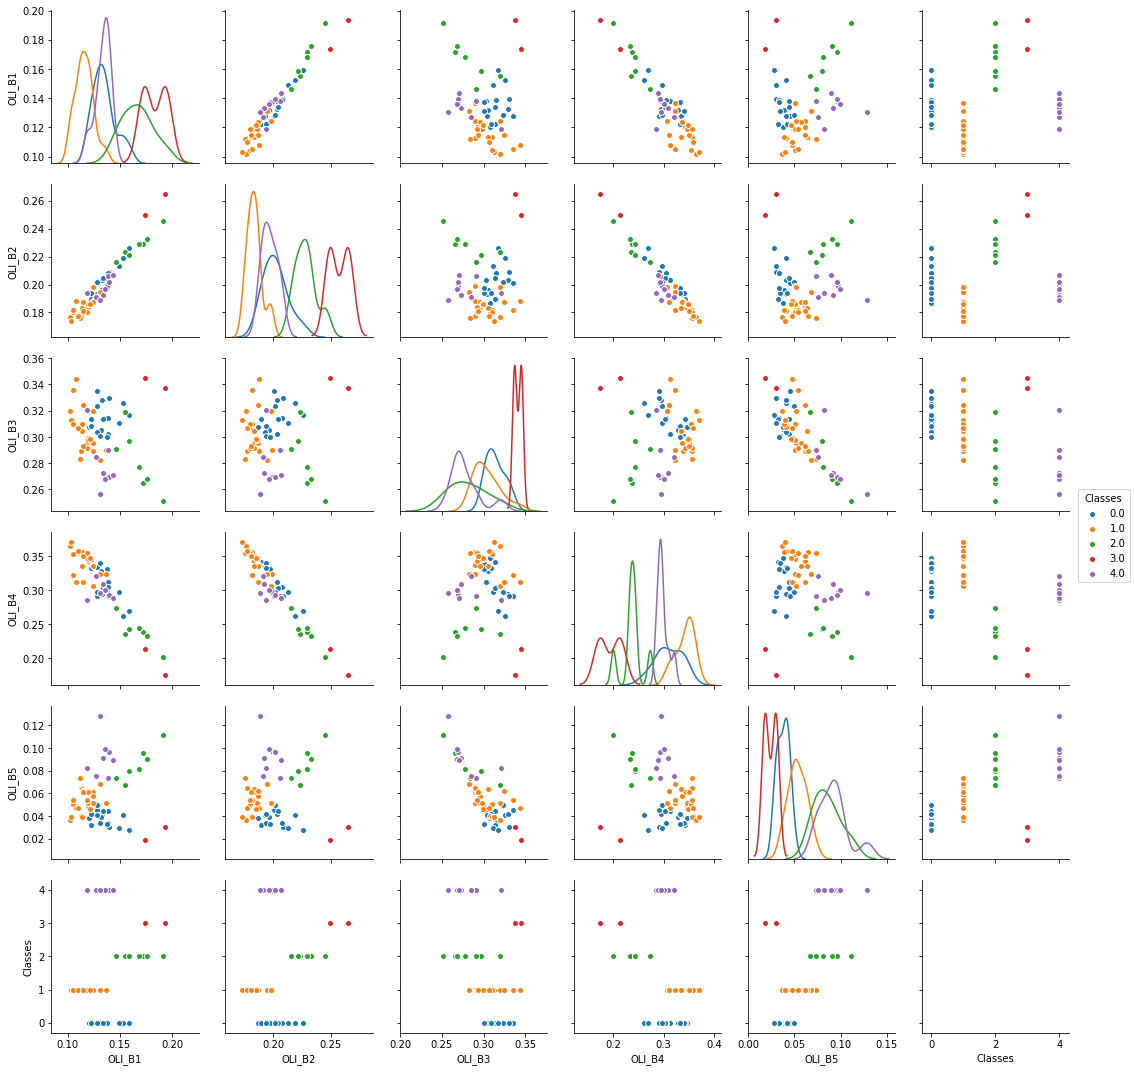

In [16]:
print('Distribuição das classes no sensor OLI Normalizado');
sns.pairplot(OLI_Norm_Train, hue='Classes',diag_kind='kde');

Distribuição das classes no sensor MSIA não normalizado


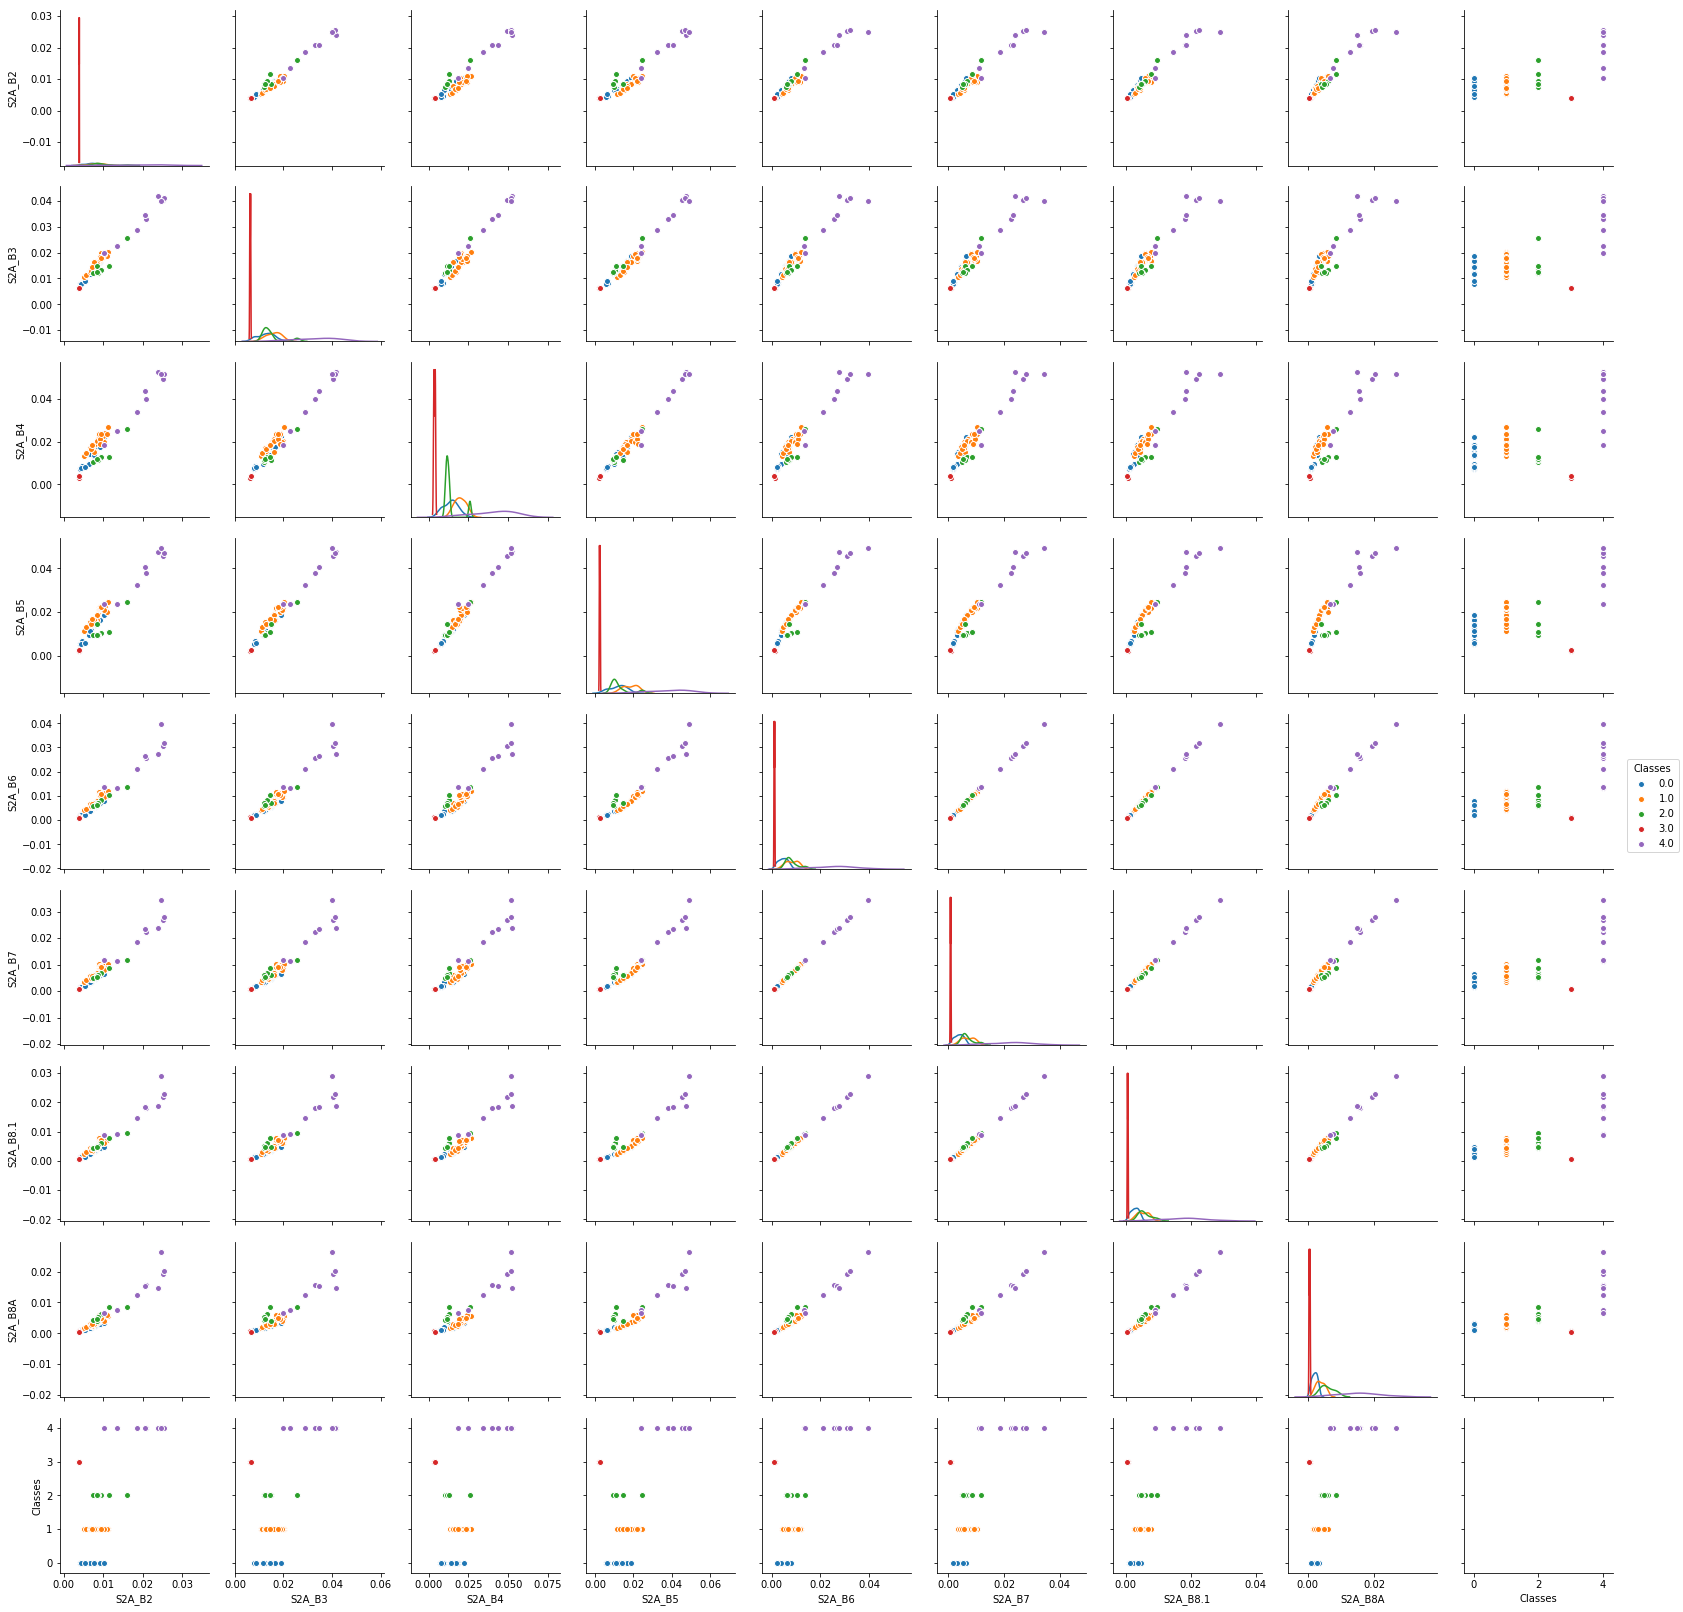

In [17]:
print('Distribuição das classes no sensor MSIA não normalizado');
sns.pairplot(MSIA_Train, hue='Classes',diag_kind='kde');

Distribuição das classes no sensor MSIA Normalizado


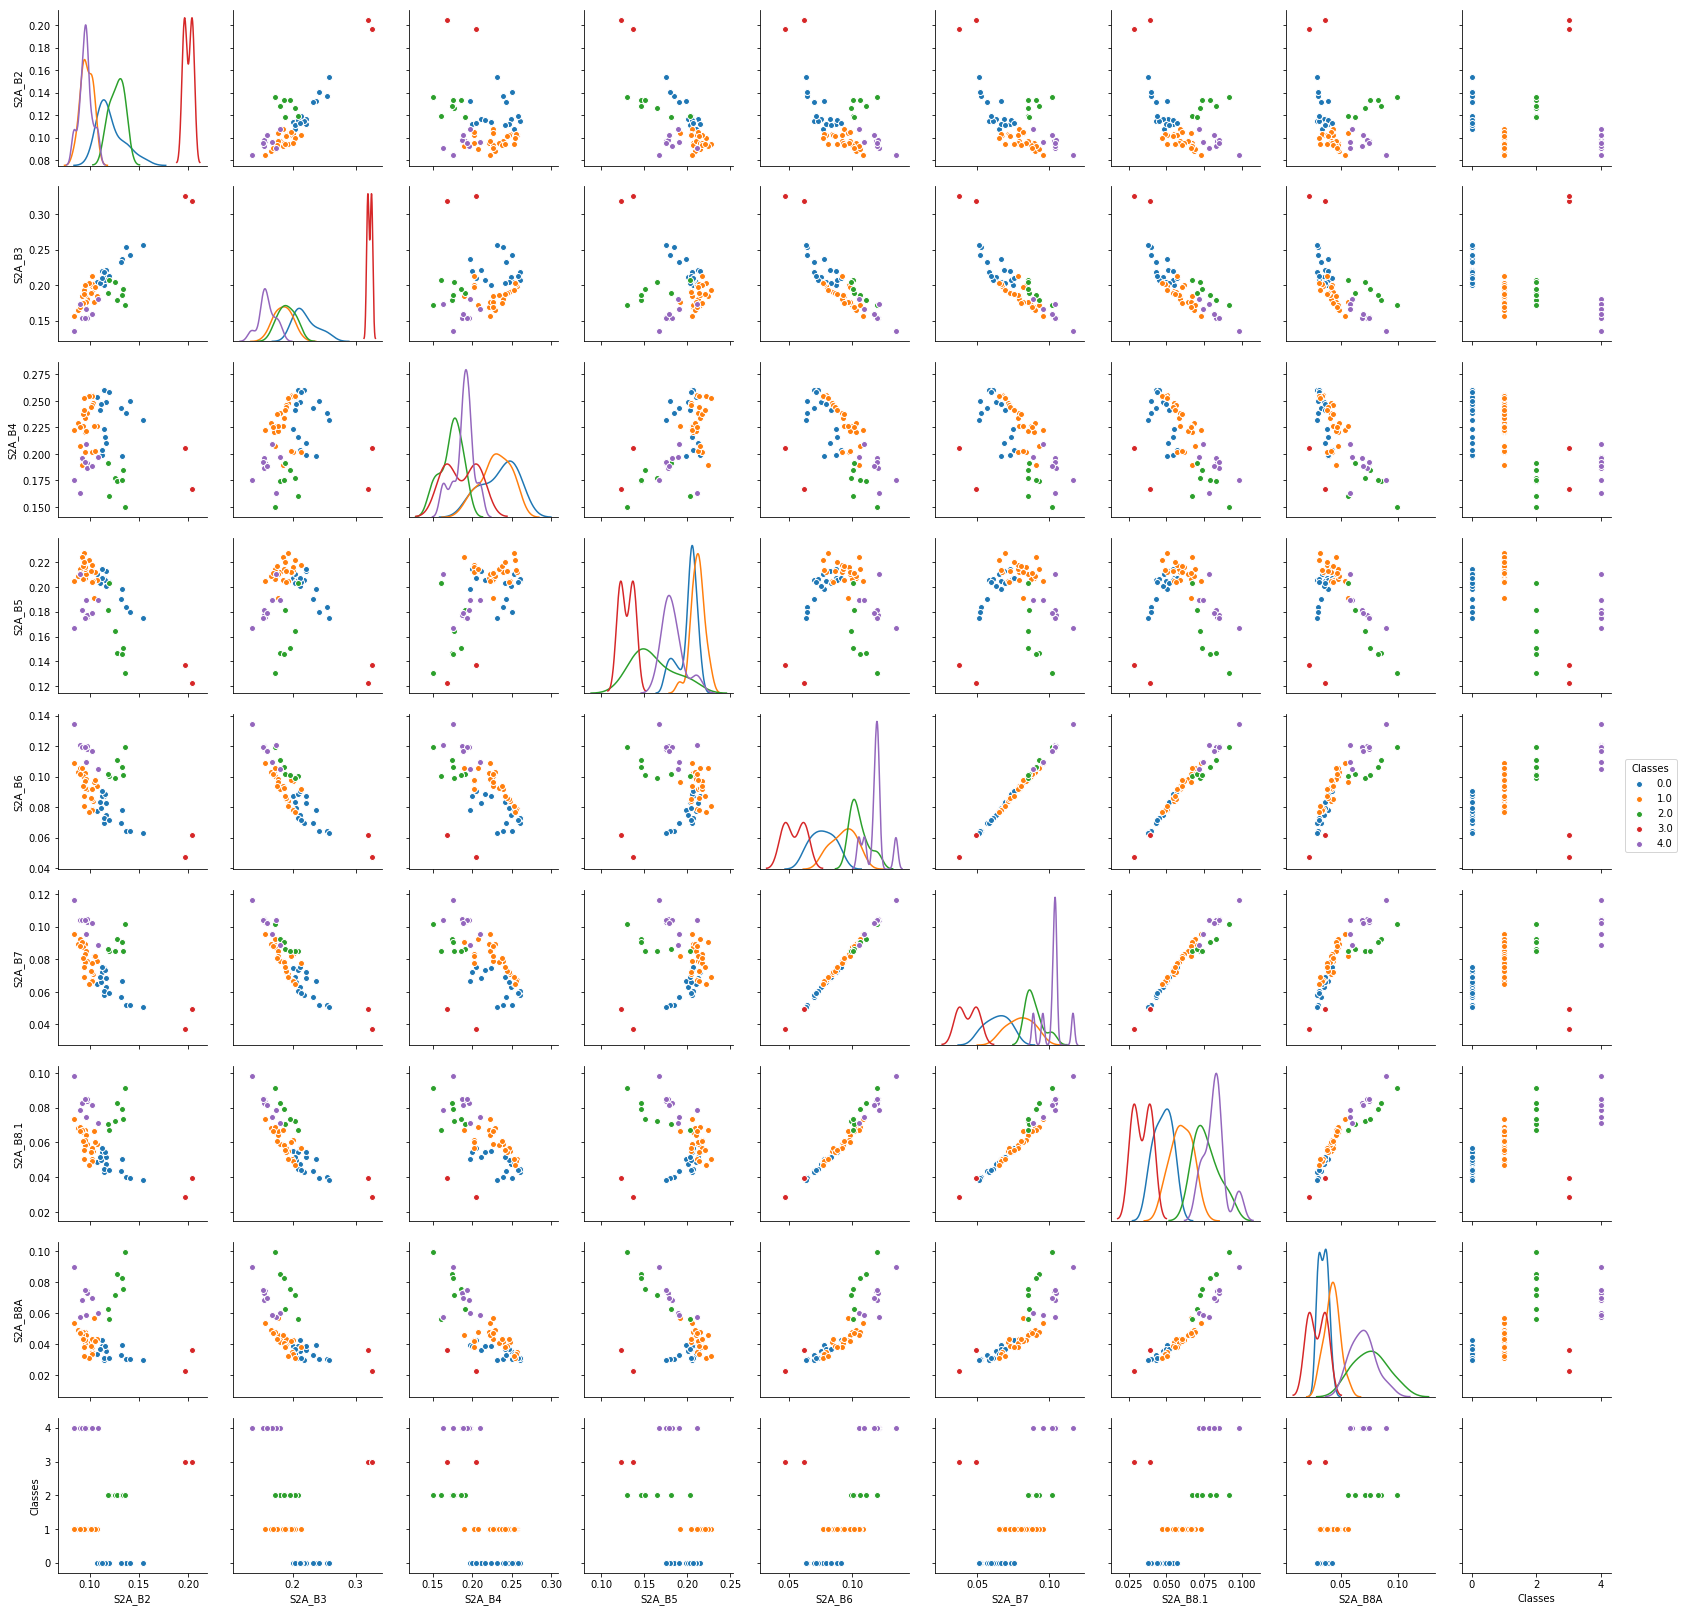

In [18]:
print('Distribuição das classes no sensor MSIA Normalizado');
sns.pairplot(MSIA_Norm_Train, hue='Classes',diag_kind='kde');

Podemos observar na distribuição de pontos das bandas não normalizadas 2 padrões: (1) Apenas a classe 3 consegue ser distinguida de todas as classes, por ter valores de Rrs superiores a todas as outras classes; (2) As bandas possuem uma alta correlação.

Na normalização das bandas, podemos observar que maioria das bandas são descorrelacionadas e se formam agrupamentos das classes, o que pode facilitar na classificação supervisionada utilizando dados multiespectrais para se detectar classes de águas definidas por dados hiperespectrais normalizados (classificados pela sua forma espectral).

Além disso, visualizando o histogramas de todas as bandas normalizadas, podemos observar que a árvore de decisão pode não ser um método adequado para a classificação multi espectral, pois, não há um bom limiar para separar uma classe de outras.

#### 4.5 Classificação supervisionada de classes de água espectrais

In [19]:
# Importando classificadores necessários
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Gerando datasets de TESTE para os classificadores supervisionados

# Gerando uma referencia para concatenar todos datasets para as mesmas amostras de teste
Reference = X_test[X_test.columns[0]]
Reference.name='Reference'

# Gerando um dataframe para o espectro original para o teste
Spec_Test = Spec.join(Reference).dropna()[Spec.columns]

# Gerando um dataframe para as bandas OLI simuladas com as classes atribuídas
OLI_Test = OLI.join(Reference).dropna()[OLI.columns]

# Gerando um dataframe para as bandas OLI simuladas com as classes atribuídas
MSIA_Test = MSIA.join(Reference).dropna()[MSIA.columns]

# Gerando um dataframe para as bandas OLI simuladas com as classes atribuídas
MSIB_Test = MSIB.join(Reference).dropna()[MSIB.columns]

# Gerando um dataframe para as bandas OLI simuladas e normalizadas com as classes atribuídas
OLI_Norm_Test = OLI_Norm.join(Reference).dropna()[OLI_Norm.columns]

# Gerando um dataframe para as bandas OLI simuladas e normalizadas com as classes atribuídas
MSIA_Norm_Test = MSIA_Norm.join(Reference).dropna()[MSIA_Norm.columns]

# Gerando um dataframe para as bandas OLI simuladas e normalizadas com as classes atribuídas
MSIB_Norm_Test = MSIB_Norm.join(Reference).dropna()[MSIB_Norm.columns]

# Criando uma lista de todos datasets de treino para os classificadores supervisionados
datasetsTest = ['X_test','Spec_Test','OLI_Test','MSIA_Test','MSIB_Test','OLI_Norm_Test',
            'MSIA_Norm_Test','MSIB_Norm_Test']

Utilizando o classificador SAM (Spectral Angle Mapper)

In [31]:
# Classificação utilizando SAM, utilizando o espectro normalizado

from spectral import spectral_angles
data = X_test[X_test.columns[0:501]].values.reshape((1,len(X_test),501))
endmembers = X_train_mean.transpose().values.reshape((5,501))
angles = spectral_angles(data, endmembers)
anglesClass = pd.DataFrame(angles[0], index = X_test.index)
anglesClass['SAMClasses'] = 'nan'

for x in anglesClass.index:

    i=1
    
    for y in anglesClass.columns[0:5]:
        
        if anglesClass[y].loc[x] < i:
            i = anglesClass[y].loc[x]
            classe = y


    anglesClass['SAMClasses'].loc[x] = classe

# classes geradas pelo SAM
anglesClass = anglesClass['SAMClasses']

Classificador utilizando GPC

In [61]:
# Importando classificador
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# 1. Classificando utilizando todos datasets (espectros, bandas e dados normalizados) através do random forest
# DataFrame de resultados da classificação teste
Test_Results = pd.DataFrame(index=X_test.index)

for x,y in zip(datasetsTrain, datasetsTest):
    
    # 1.1 Inserindo parâmetros do classificador
    
    #features = len(eval(x).columns[0:-1])
    GPC = GaussianProcessClassifier(1.0 * RBF(1.0));
    
    # 1.2 Treinando o classificados
    Classes = eval(x)['Classes']
    Atributos = eval(x)[eval(x).columns[0:-1]]
    GPC.fit(Atributos, Classes)
    
    # 1.3 Classificando os dados de teste
    Predicted = GPC.predict(eval(y))
    Predicted2 = pd.DataFrame(Predicted,columns=[y], index=(eval(y)).index)

    # 1.4 Salvando as classes
    Test_Results = Test_Results.join(Predicted2)

for x in Test_Results:
    index = [int(y) for y in Test_Results[x]]
    Test_Results[x] = index

In [62]:
# Juntando os resultados da classificação SAM com a GPC
Test_Results = Test_Results.join(anglesClass)

###### 4.5.1 Visualizando as matrizes de confusão

Com todas classificações realizadas, serão comparadas a classificação GPC utilizando o espectro normalizado - o qual foi utilizado para definir as classes na classificação não supervisionada - com as classificações SAM, classificação pelas bandas OLI originais, OLI normalizadas, MSI A original e MSI B normalizada

In [77]:
# Importando a função de matriz de confusão
from sklearn.metrics import confusion_matrix
Test_Results.columns

Index(['X_test', 'Spec_Test', 'OLI_Test', 'MSIA_Test', 'MSIB_Test',
       'OLI_Norm_Test', 'MSIA_Norm_Test', 'MSIB_Norm_Test', 'SAMClasses'],
      dtype='object')

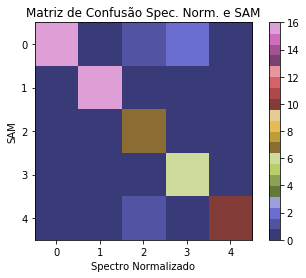

In [81]:
# Gerando a matriz de confusão entre Spectro normalizado e SAM
matriz_specN_SAM = confusion_matrix(Test_Results[Test_Results.columns[0]],Test_Results[Test_Results.columns[-1]])
plt.imshow(matriz_specN_SAM, cmap='tab20b')
plt.colorbar()
plt.title('Matriz de Confusão Spec. Norm. e SAM')
plt.xlabel('Spectro Normalizado')
plt.ylabel('SAM');

A normalização pela integral (ou soma) do espectro e a classificação SAM, têm a proposta de se diferenciar espectros pela forma espectral, e não pela intensidade.Entretanto, utilizando uma classificação GPC para o espectro normalizado, elas tem algumas diferenças na classificação, observado pelos erros na matriz de confusão. Por outro lado, esses erros são relativamente baixos, onde há 4 amostras classificadas diferentes, para um conjunto de dados de 59 de amostras de teste.

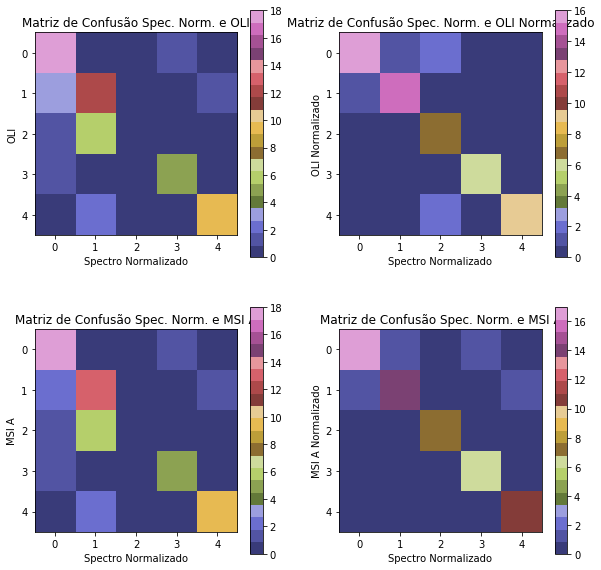

In [83]:
# Gerando a matriz de confusão para as bandas OLI e MSI a
plt.figure(figsize=(10,10))
matriz_specN_SAM = confusion_matrix(Test_Results[Test_Results.columns[0]],Test_Results[Test_Results.columns[2]])

ax1 = plt.subplot(2,2,1)
plt.imshow(matriz_specN_SAM, cmap='tab20b')
plt.colorbar()
plt.title('Matriz de Confusão Spec. Norm. e OLI')
plt.xlabel('Spectro Normalizado')
plt.ylabel('OLI')

matriz_specN_SAM = confusion_matrix(Test_Results[Test_Results.columns[0]],Test_Results[Test_Results.columns[5]])

ax1 = plt.subplot(2,2,2)
plt.imshow(matriz_specN_SAM, cmap='tab20b')
plt.colorbar()
plt.title('Matriz de Confusão Spec. Norm. e OLI Normalizado')
plt.xlabel('Spectro Normalizado')
plt.ylabel('OLI Normalizado')

matriz_specN_SAM = confusion_matrix(Test_Results[Test_Results.columns[0]],Test_Results[Test_Results.columns[3]])

ax1 = plt.subplot(2,2,3)
plt.imshow(matriz_specN_SAM, cmap='tab20b')
plt.colorbar()
plt.title('Matriz de Confusão Spec. Norm. e MSI A')
plt.xlabel('Spectro Normalizado')
plt.ylabel('MSI A')

matriz_specN_SAM = confusion_matrix(Test_Results[Test_Results.columns[0]],Test_Results[Test_Results.columns[6]])

ax1 = plt.subplot(2,2,4)
plt.imshow(matriz_specN_SAM, cmap='tab20b')
plt.colorbar()
plt.title('Matriz de Confusão Spec. Norm. e MSI A')
plt.xlabel('Spectro Normalizado')
plt.ylabel('MSI A Normalizado');

Observando as matrizes de confusão acima, fica evidente que normalizar as bandas dos sensores OLI e MSI A pela soma das bandas melhora a classificação multi espectral. Portanto, para classes definidadas pela forma do espectro através de dados hiperepectrais, normalizar as bandas pela soma pode permitir fazer o mapeamento das classes obtidas in situ, utilizando os sensores orbitais OLI e Sentinel 2 MSI.

###### 4.5.2 Comparação dos espectros de treino e os obtido pelas classificações através do espectro normalizado, SAM, OLI e MSI A normalizado

In [84]:
#Concatena os classes com a Rrs normalizada
All_test_results = X_test.join(Test_Results)

Comparação entre o espectro das classes obtidas pelo espectro normalizado e SAM

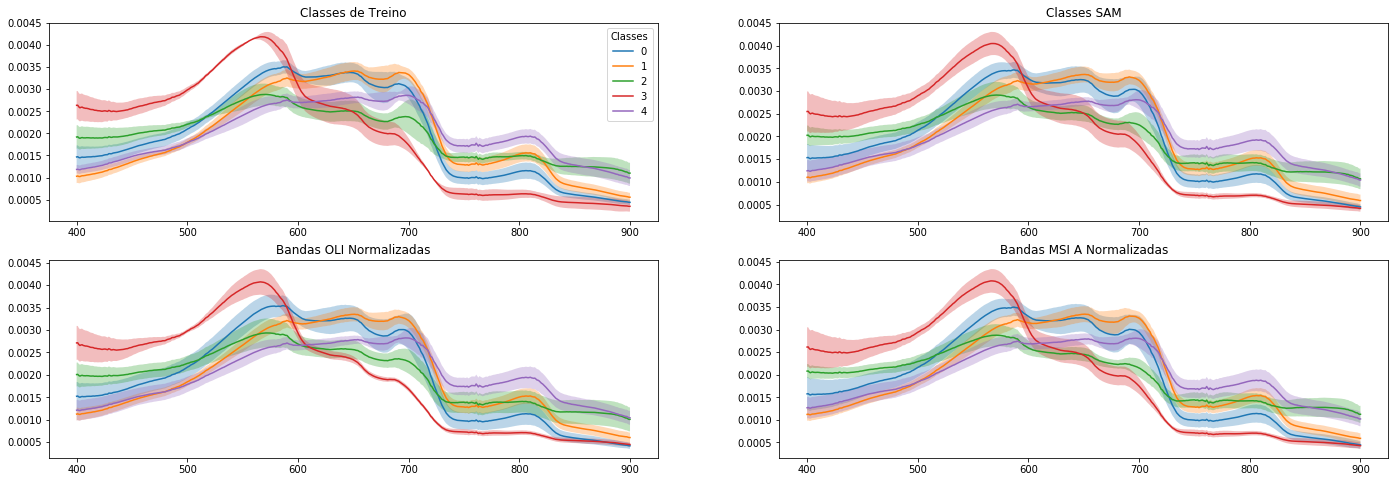

In [88]:
# Gerando os espectros para a classificação utilizando o espectro normalizado
All_test_results_mean = All_test_results.groupby('SAMClasses').mean()
All_test_results_std = All_test_results.groupby('SAMClasses').std()

index = [int(x) for x in All_test_results_mean.columns[0:501]]
All_test_results_mean = All_test_results_mean[All_test_results_mean.columns[0:501]].transpose()
All_test_results_mean.index = index

index = [int(x) for x in All_test_results_std.columns[0:501]]
All_test_results_std = All_test_results_std[All_test_results_std.columns[0:501]].transpose()
All_test_results_std.index = index

#Gerando o gráfico de visualização das classes obtidas
plt.figure(figsize=(24,8))

ax1=plt.subplot(2,2,2)
All_test_results_mean.plot(ax=ax1, legend=False)
plt.title('Classes SAM')
for x in All_test_results_mean:
    plt.fill_between(All_test_results_mean.index,
                     (All_test_results_mean[x] - All_test_results_std[x]),
                     (All_test_results_mean[x] + All_test_results_std[x]), alpha=0.3)



ax2=plt.subplot(2,2,1)
X_train_mean.plot(ax=ax2)
plt.title("Classes de Treino")
for x in X_train_mean:
    plt.fill_between(X_train_mean.index,(X_train_mean[x] - X_train_std[x]),(X_train_mean[x] + X_train_std[x]), alpha=0.3)
    
    
    

All_test_results_mean = All_test_results.groupby('OLI_Norm_Test').mean()
All_test_results_std = All_test_results.groupby('OLI_Norm_Test').std()

index = [int(x) for x in All_test_results_mean.columns[0:501]]
All_test_results_mean = All_test_results_mean[All_test_results_mean.columns[0:501]].transpose()
All_test_results_mean.index = index

index = [int(x) for x in All_test_results_std.columns[0:501]]
All_test_results_std = All_test_results_std[All_test_results_std.columns[0:501]].transpose()
All_test_results_std.index = index

ax3=plt.subplot(2,2,3)
All_test_results_mean.plot(ax=ax3, legend=False)
plt.title('Bandas OLI Normalizadas')
for x in All_test_results_mean:
    plt.fill_between(All_test_results_mean.index,
                     (All_test_results_mean[x] - All_test_results_std[x]),
                     (All_test_results_mean[x] + All_test_results_std[x]), alpha=0.3)
    

All_test_results_mean = All_test_results.groupby('MSIA_Norm_Test').mean()
All_test_results_std = All_test_results.groupby('MSIA_Norm_Test').std()

index = [int(x) for x in All_test_results_mean.columns[0:501]]
All_test_results_mean = All_test_results_mean[All_test_results_mean.columns[0:501]].transpose()
All_test_results_mean.index = index

index = [int(x) for x in All_test_results_std.columns[0:501]]
All_test_results_std = All_test_results_std[All_test_results_std.columns[0:501]].transpose()
All_test_results_std.index = index

ax4=plt.subplot(2,2,4)
All_test_results_mean.plot(ax=ax4, legend=False)
plt.title('Bandas MSI A Normalizadas')
for x in All_test_results_mean:
    plt.fill_between(All_test_results_mean.index,
                     (All_test_results_mean[x] - All_test_results_std[x]),
                     (All_test_results_mean[x] + All_test_results_std[x]), alpha=0.3)

Como observado acima, a classificação SAM e as utilizando as bandas dos sensores OLI e MSI A, conseguem reproduzir a forma espectral das classes de treino, definidas pela classificação não supervisionada.

# Conclusão
O objetivo deste trabalho é de investigar se classes espectrais de água definidas por dados hisperespectrais podem ser detectados por sensores multiespectrais (OLI e MSI). É mostrado que para classes espectrais definidas pela forma do espectro, utilizar os valores absorlutos de Rrs das bandas dos sensores não é adequado para se detectar as classes hiperespectrais. Por outro lado, a normalização das bandas pela a sua soma total permite a classificação das classes definidas hiperespectralmente.
Portanto, em futuros estudos que se objetivem classificar águas espectralmente para uma análise qualitativa, ou para a otimização de algoritmos biofísicos, combinar a capacidade de se distinguir classes espectrais de água com a cobertura espacial e temporal de sensores, pode ser realizada.